In [1]:
import numpy as np
from astropy import coordinates as coo
from astropy import units as u
import healpy as hp
import matplotlib.pyplot as plt
import multiprocessing as mp
from astropy.io import fits
from data_process import calculate_jackknife_variance, load_calculation_data, calculate_jackknife_variance_global

Test different estimator.

Now the estimator is dd-dr, which means quasar-kappa - random-kappa. other possible estimator is dd - rd, which means quasar-kappa - quasar-shuffled kappa; and dd - dr - rd + rr. here rr is random-shuffled kappa.

In [2]:
Nside_jack = 4

In [7]:
r_p, dd = load_calculation_data(f'../calculation_data/dd.npy', return_rp=True)
rd = load_calculation_data(f'../calculation_data/rd.npy')
rr = load_calculation_data(f'../calculation_data/rr.npy')
dr = load_calculation_data(f'../calculation_data/dr.npy')

quasar_cata = np.load('../catalogue/quasar_lss_all.npy')
c = coo.SkyCoord(ra=quasar_cata['ra']*u.degree, dec=quasar_cata['dec']*u.degree)

l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pix_d = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

print('finish loading quasar catalogue')

random_sample = np.load('../catalogue/random_quasar_lss_all.npy')
c = coo.SkyCoord(ra=random_sample['ra']*u.degree, dec=random_sample['dec']*u.degree)

l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pix_r = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

print('finish loading random sample')

finish loading quasar catalogue
finish loading random sample


In [8]:
dd_res = calculate_jackknife_variance_global(dd[0], dd[1], pix_d, norm_cov=True)
dr_res = calculate_jackknife_variance_global(dr[0], dr[1], pix_d, norm_cov=True)
rd_res = calculate_jackknife_variance_global(rd[0], rd[1], pix_r, norm_cov=True)
rr_res = calculate_jackknife_variance_global(rr[0], rr[1], pix_r, norm_cov=True)

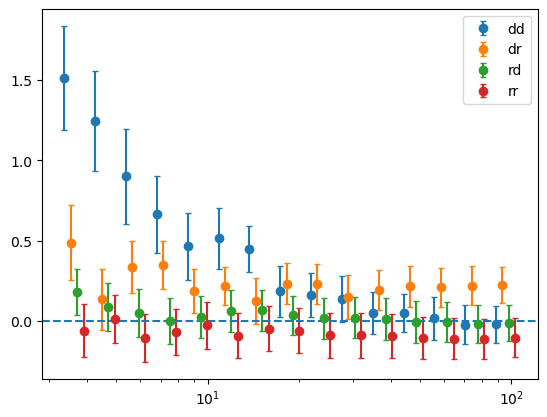

In [9]:
shift = 1.01
r = r_p
plt.errorbar(r, dd_res['mean'], dd_res['std'], label='dd', fmt='o', capsize=2)
r *= 1.05
plt.errorbar(r, dr_res['mean'], dr_res['std'], label='dr', fmt='o', capsize=2)
r *= 1.05
plt.errorbar(r, rd_res['mean'], rd_res['std'], label='rd', fmt='o', capsize=2)
r *= 1.05
plt.errorbar(r, rr_res['mean'], rr_res['std'], label='rr', fmt='o', capsize=2)
plt.axhline(y=0, linestyle='--')
plt.semilogx()
plt.legend()

In [18]:
ls = []
for i in range(1, 8):

    dr = load_calculation_data(f'../calculation_data/result_r=3_100_15_quasar_lss_all_CMB_lcut_2048_partly_shuffle_{i}_tree.npy')
    dr_res = calculate_jackknife_variance_global(dr[0], dr[1], pix_d, norm_cov=True)
    ls.append(dr_res)

[]

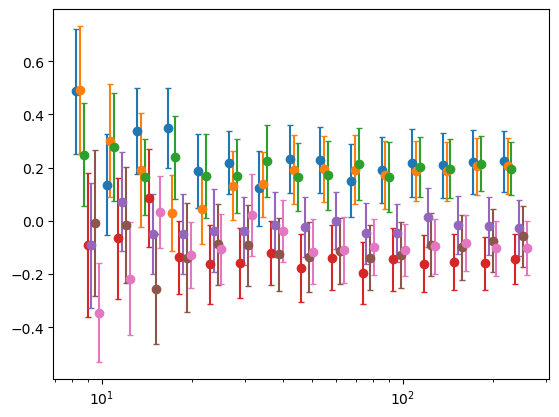

In [24]:
shift = 1+3e-2
r = r_p
for res in ls:
    plt.errorbar(r, res['mean'], res['std'], fmt='o', capsize=2)
    r *= shift
plt.semilogx()

In [ ]:
dd_rd_res = calculate_jackknife_variance_global(dd[0], dd[1], pix_d, rd[0], rd[1], pix_r, norm_cov=True)
dd_dr_res = calculate_jackknife_variance_global(dd[0], dd[1], pix_d, dr[0], dr[1], pix_d, norm_cov=True)

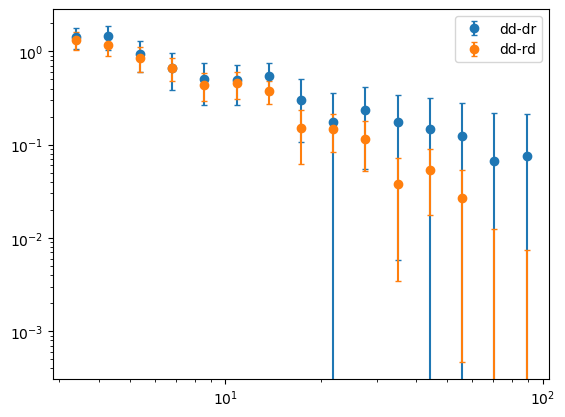

In [10]:
plt.errorbar(r_p, dd_dr_res['mean'], dd_dr_res['std'], label='dd-dr', fmt='o', capsize=2)
plt.errorbar(r_p, dd_rd_res['mean'], dd_rd_res['std'], label='dd-rd', fmt='o', capsize=2)

plt.axhline(y=0, linestyle='--')
plt.loglog()
plt.legend()

In [17]:
import multiprocessing as mp
from data_process import weight_nan_mean

In [18]:
def resample_tmp(i):
    idx = pix_d != i
    idx_r = pix_r != i
    return weight_nan_mean(dd[0,idx], dd[1,idx]) - \
        weight_nan_mean(dr[0,idx], dr[1,idx]) - \
        weight_nan_mean(rd[0,idx_r], rd[1,idx_r]) + \
        weight_nan_mean(rr[0,idx_r], rr[1,idx_r])

In [19]:
pro = mp.Pool(30)
unique_label = np.unique(pix_d)
jack_val = np.vstack(pro.map(resample_tmp, unique_label))

In [21]:
val = jack_val.mean(axis=0)
std = jack_val.std(axis=0, ddof=0)*np.sqrt(len(unique_label)-1)

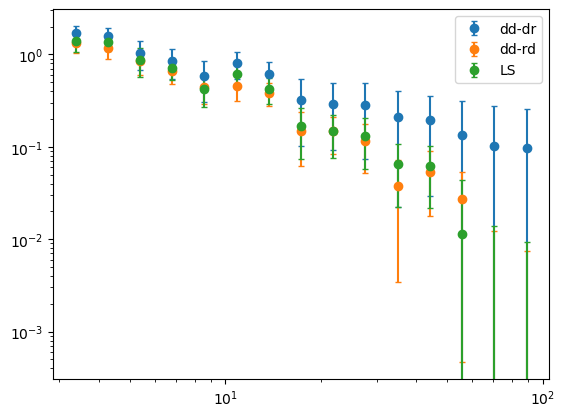

In [22]:
plt.errorbar(r_p, dd_dr_res['mean'], dd_dr_res['std'], label='dd-dr', fmt='o', capsize=2)
plt.errorbar(r_p, dd_rd_res['mean'], dd_rd_res['std'], label='dd-rd', fmt='o', capsize=2)
plt.errorbar(r_p, val, std, label='LS', fmt='o', capsize=2)

plt.axhline(y=0, linestyle='--')
plt.loglog()
plt.legend()

## signal

In [18]:
np.savetxt(f'./results/quasar_lss_all_cmb_lcut_{lmax}', np.c_[r_p, sampler_sub['mean'], sampler_sub['std']])

In [21]:
from astropy.cosmology import Planck18 as cosmos
h = cosmos.H0.value/100

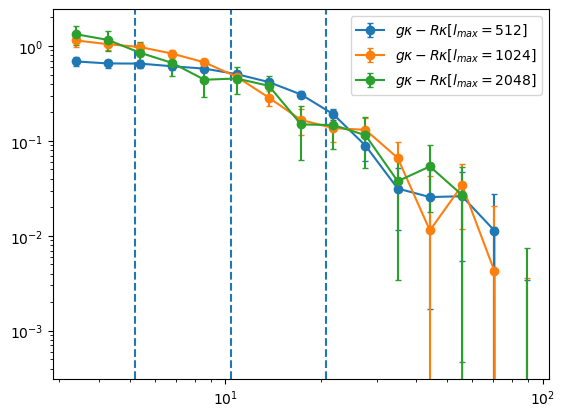

In [24]:
for l in [512, 1024, 2048]:
    res = np.loadtxt(f'./results/quasar_lss_all_cmb_lcut_{l}')
    angular_scale = 200/l * np.pi/180
    plt.errorbar(res[:,0], res[:,1], res[:,2], capsize=2, fmt='-o', label='$g\\kappa-R\\kappa[l_{max} = %s]$'%(l,))
    z = quasar_cata['z'].mean()
    distance = cosmos.comoving_distance(z).to('Mpc').value*h
    plt.axvline(x=distance*angular_scale, linestyle='--')
plt.loglog()
plt.legend()

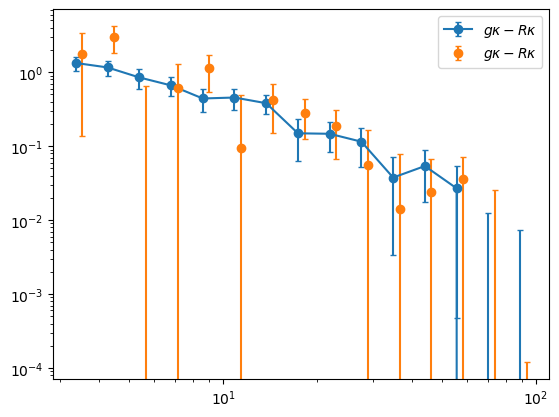

In [17]:
res_1024 = np.loadtxt('./results/quasar_lss_all_cmb_lcut_n_2048')
res_2048 = np.loadtxt('./results/quasar_lss_cmb_smoothed')
r_p = res_1024[:,0]
plt.errorbar(r_p, res_1024[:,1], res_1024[:,2], capsize=2, fmt='-o', label='$g\\kappa-R\\kappa$')
plt.errorbar(r_p*1.05, res_2048[:,1], res_2048[:,2], capsize=2, fmt='o', label='$g\\kappa-R\\kappa$')
plt.loglog()
plt.legend()